In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import catboost
import xgboost as xgb


from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

In [2]:
SEED = 88888

In [3]:
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [4]:
test = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv")
train = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv")
original = pd.read_csv("/kaggle/input/wine-quality-dataset/WineQT.csv")

In [5]:
print(f"train shape {train.shape}")
print(f"test shape {test.shape}")
print(f"original shape {original.shape}")

train shape (2056, 13)
test shape (1372, 12)
original shape (1143, 13)


In [6]:
features = ['fixed acidity', 'volatile acidity', 'citric acid',
            'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 
            'sulphates', 'alcohol']
targets = ['quality']

In [7]:
train.head(2)

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.5,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.3,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6


In [8]:
train.describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,1027.500000,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,593.660397,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,0.000000,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,513.750000,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,1027.500000,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,1541.250000,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,2055.000000,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


In [9]:
pd.unique(train["quality"])

array([6, 7, 5, 4, 8, 3])

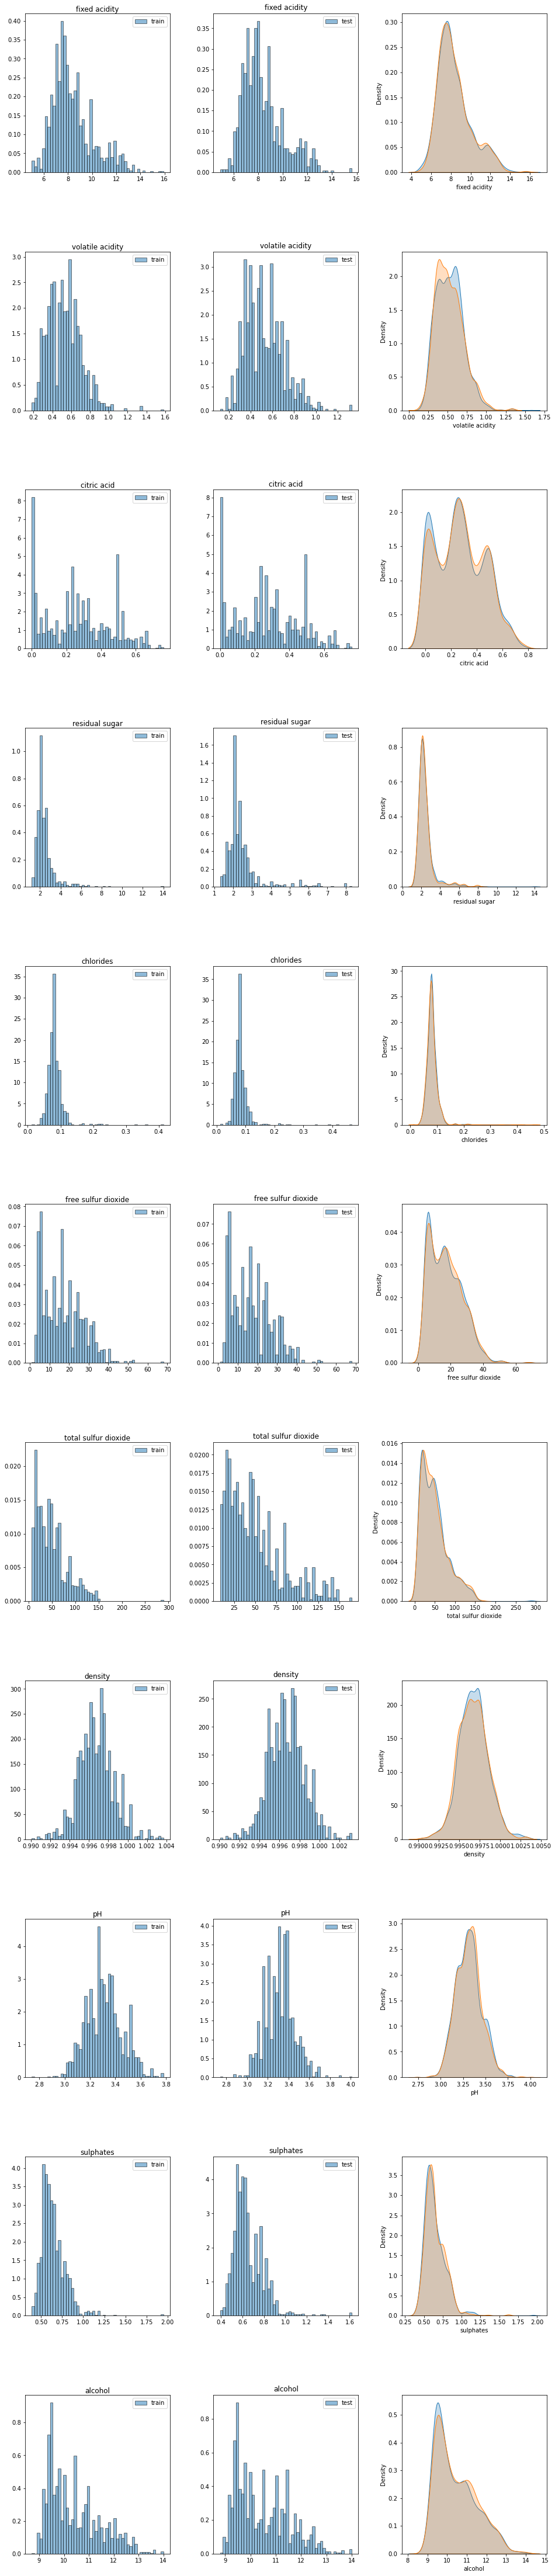

In [10]:
import seaborn as sns
colums = train.columns[1:-1]
fig, ax = plt.subplots(11, 3, figsize=(16, 80))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for i, column in enumerate(colums):
    ax[i * 3].hist(train[column],alpha=0.5, bins = 50, density=True, label='train', edgecolor="black")
    ax[i * 3+1].hist(test[column],alpha=0.5, bins =50, density=True, label='test', edgecolor="black")
    ax[i * 3].legend(loc='upper right')
    ax[i * 3].set_title(column, pad=3.5)
    ax[i * 3+1].legend(loc='upper right')
    ax[i * 3+1].set_title(column)
    sns.kdeplot(ax = ax[i*3 + 2], x = column , data = train, fill = True)
    sns.kdeplot(ax = ax[i*3 + 2], x = column , data = test, fill = True)
plt.show()


There is only 6 numbers in "quality" column  "[6, 7, 5, 4, 8, 3]"

In [11]:
print(train.columns)

Index(['Id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


In [12]:
skew_df = pd.concat((train.drop(targets,axis =1), test), axis =0).skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
print(skew_df)
skew_f = ['fixed acidity ', 'total sulfur dioxide', 'sulphates', 'residual sugar', 'chlorides']

Skewly distributed columns by skewness value:

Id                      0.000000
density                 0.164214
citric acid             0.232507
pH                      0.237687
free sulfur dioxide     0.693383
volatile acidity        0.701971
alcohol                 0.759635
fixed acidity           0.974238
total sulfur dioxide    1.195734
sulphates               1.734961
residual sugar          3.505435
chlorides               5.858161
dtype: float64


In [13]:
kurtosis_df = pd.concat((train.drop(targets,axis =1), test), axis =0).kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
print(kurtosis_df)
kurtosis_f = ['volatile acidity', 'total sulfur dioxide', 'sulphates',
              'residual sugar', 'chlorides']

Tailed columns by kurtosis value

Id                      -1.200000
citric acid             -0.871012
alcohol                 -0.234606
pH                       0.314764
free sulfur dioxide      0.326478
density                  0.706671
fixed acidity            0.762908
volatile acidity         1.080821
total sulfur dioxide     1.948939
sulphates                8.159790
residual sugar          19.725839
chlorides               65.732590
dtype: float64


### Some features are distributed not normal and have skewness and kurtosis

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


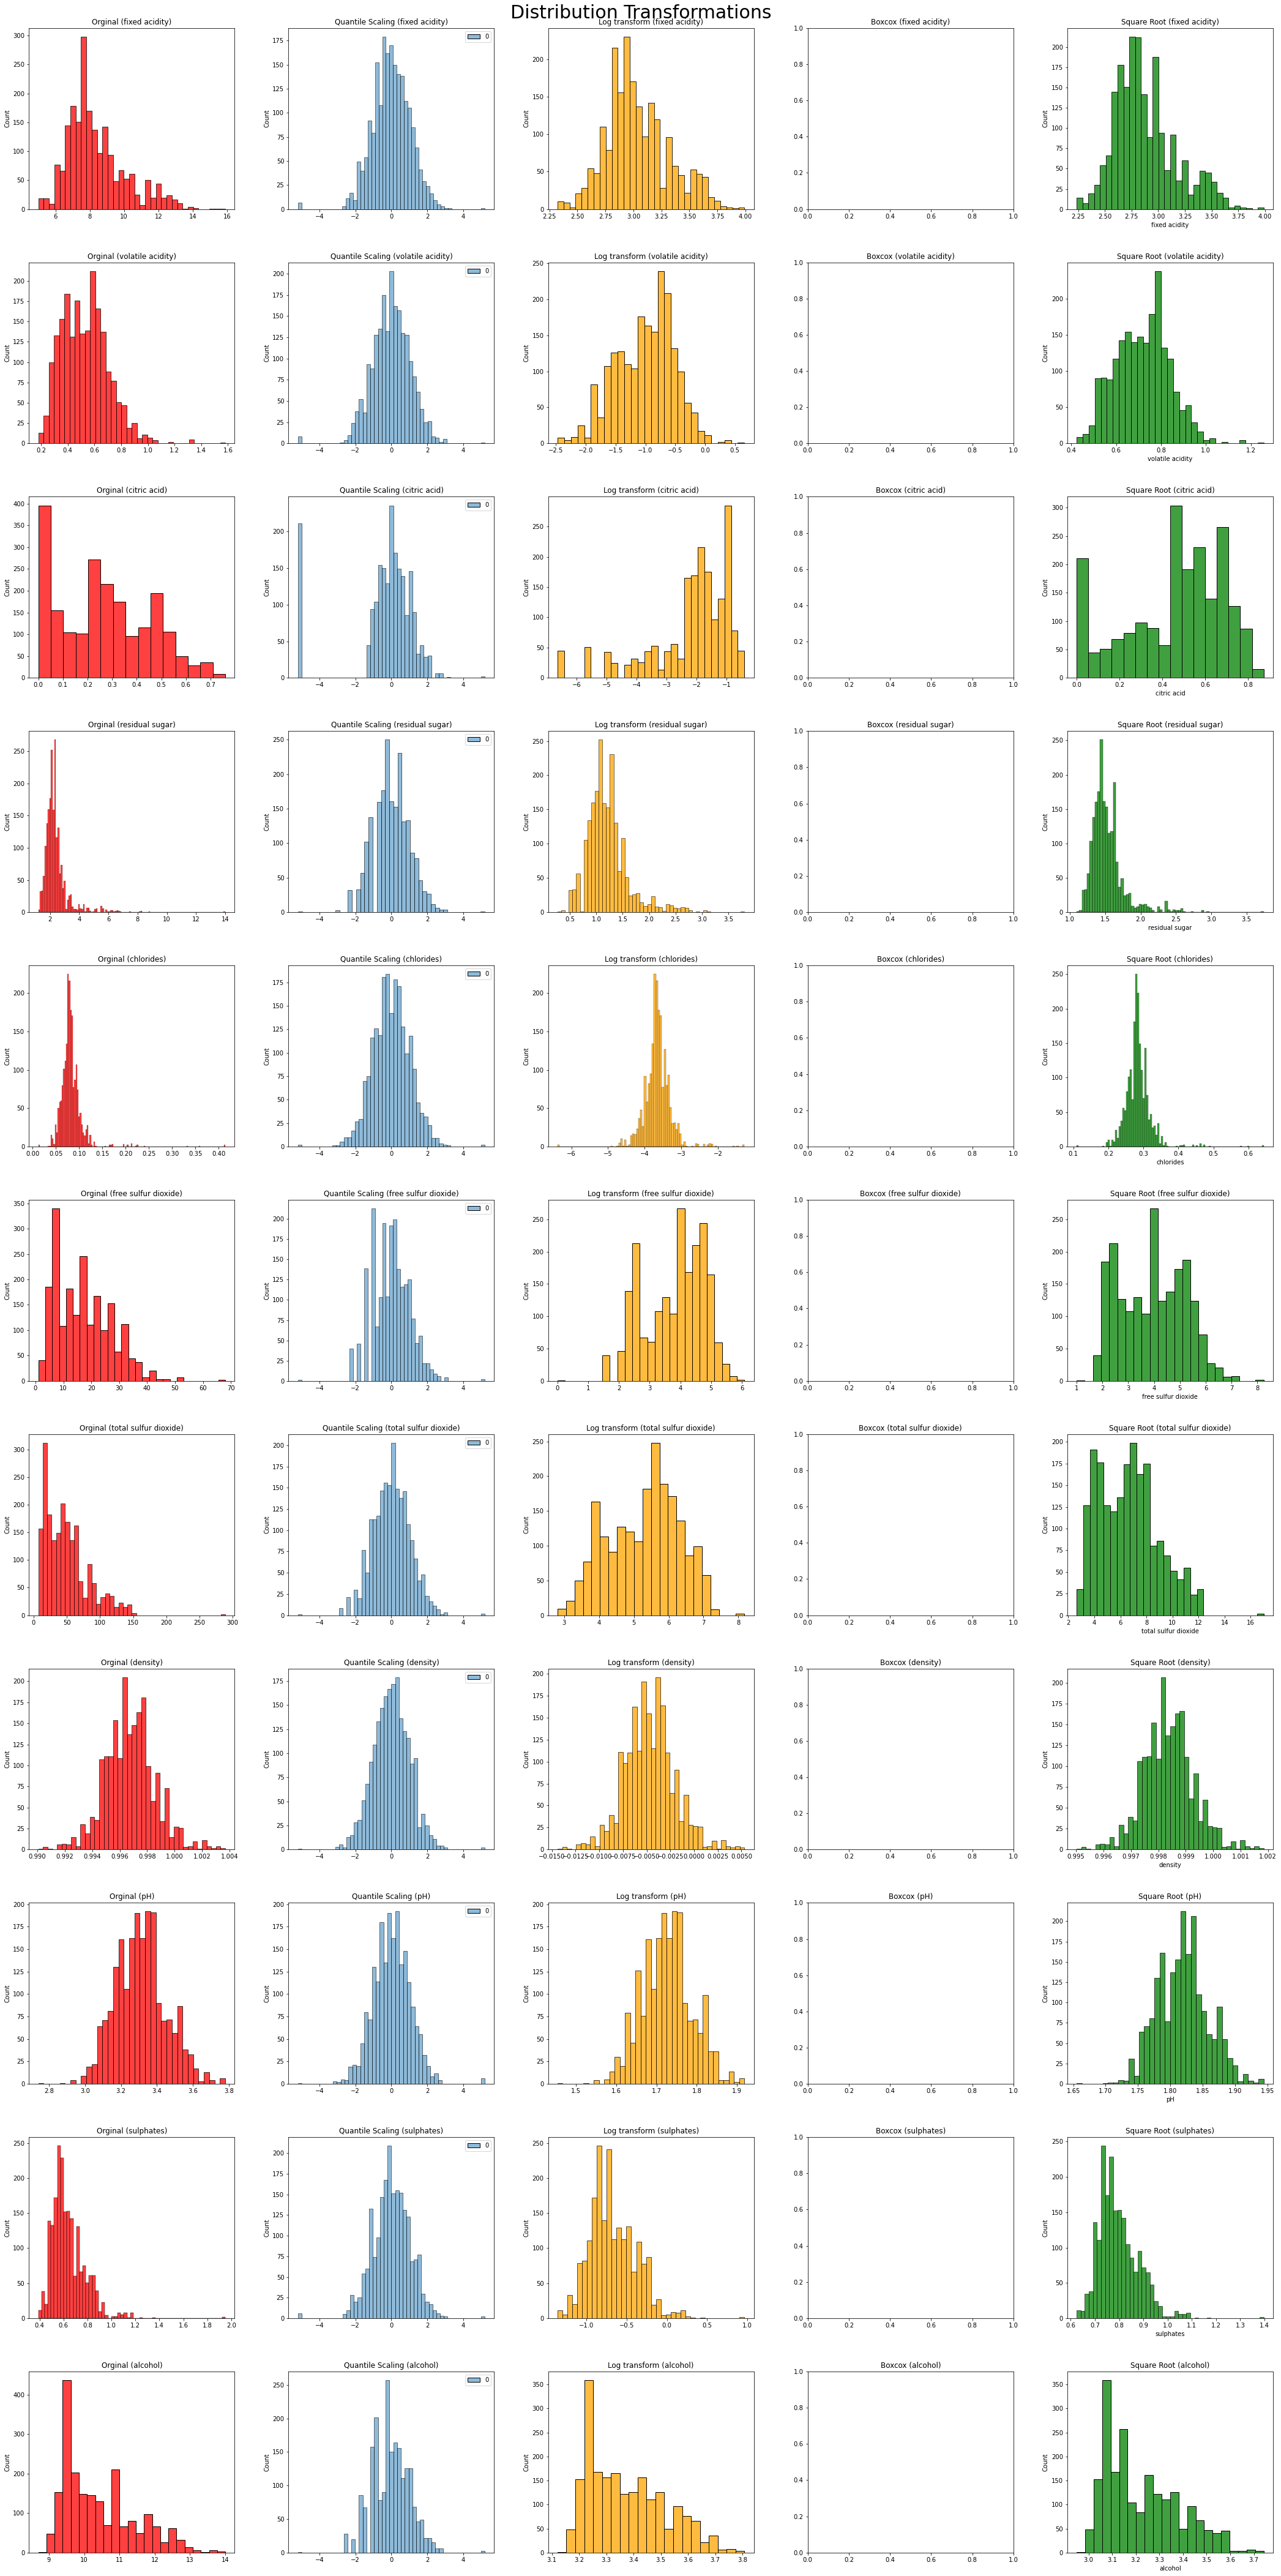

In [14]:

features_col = ['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
from sklearn.preprocessing import QuantileTransformer

fig,ax = plt.subplots(len(features_col),5, figsize = (30,60))
for i,col in enumerate(features_col):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(train[[col]])

    sns.histplot(x=train[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log2(train[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(train[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(train[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

## Model selection

### Test different algorithms without others technics

In [15]:
train = pd.concat([train, original], axis=0)

In [16]:
def create_new_features(df):
    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['acid/density'] = df['total_acid']  / df['density']
    df['alcohol_density'] = df['alcohol']  * df['density']
    df['sulphate/density'] = df['sulphates']  / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
    
    return df


In [17]:
train_df = create_new_features(train) 

In [18]:
features_df = train_df.drop(["Id", "quality"], axis=1)
scaler = QuantileTransformer(output_distribution="normal")
train_scl = scaler.fit_transform(features_df)
print(type(train_scl ))
features_df = pd.DataFrame(train_scl, columns = features_df.columns)
targets_df = train["quality"]
X_train, X_valid, y_train, y_valid = train_test_split(features_df, targets_df, test_size=0.2 , random_state=SEED)

<class 'numpy.ndarray'>


In [19]:
#df = pd.DataFrame(train_scl, columns = features.columns)

In [20]:
#features = df

In [21]:
print(f"X_train shape {X_train.shape}")
print(f"X_valid shape {X_valid.shape}")

X_train shape (2559, 18)
X_valid shape (640, 18)


In [22]:

rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=88888)

In [23]:
y_pred = rfc.predict(X_valid)

In [24]:
    print(f"Accuracy Score for {accuracy_score(y_valid, y_pred)}", )
    print(f"F1 Score for {f1_score(y_valid ,y_pred, average='weighted')}")    
    quadratic_weighted_kappa(y_valid, y_pred)

Accuracy Score for 0.6265625
F1 Score for 0.6062512465190789


0.534727494421055

In [25]:
quadratic_weighted_kappa(y_valid, y_pred)

0.534727494421055

In [26]:
xgbc = xgb.XGBClassifier(n_estimators=5, max_depth=3, learning_rate=1, objective='binary:logistic')
xgbc.fit(X_train, y_train-3)

x_pred_xgb = xgbc.predict(X_valid)

print(f"Accuracy Score for {accuracy_score(y_valid - 3, x_pred_xgb)}", )
print(f"F1 Score for {f1_score(y_valid - 3 ,x_pred_xgb, average='weighted')}")   
quadratic_weighted_kappa(y_valid - 3, x_pred_xgb)

Accuracy Score for 0.590625
F1 Score for 0.5742692085566491


0.49428292578100497

<AxesSubplot:>

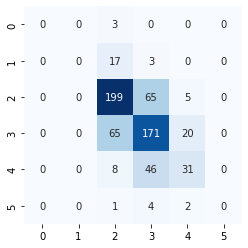

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [28]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(sampling_strategy={3: 100, 4: 100, 7:500, 8:100},
                                random_state=SEED,
                                k_neighbors = 3,
                                 
                                ).fit_resample(X_train, y_train)

#Original dataset shape Counter({1: 900, 0: 100})

In [29]:
xgbc = xgb.XGBClassifier(n_estimators=5, max_depth=3, learning_rate=1, objective='binary:logistic')
xgbc.fit(X_train, y_train-3)
x_pred_xgb = xgbc.predict(X_valid)
print(f"Accuracy Score for {accuracy_score(y_valid - 3, x_pred_xgb)}", )
print(f"F1 Score for {f1_score(y_valid - 3 ,x_pred_xgb, average='weighted')}")   
quadratic_weighted_kappa(y_valid - 3, x_pred_xgb)

Accuracy Score for 0.590625
F1 Score for 0.5742692085566491


0.49428292578100497

<AxesSubplot:>

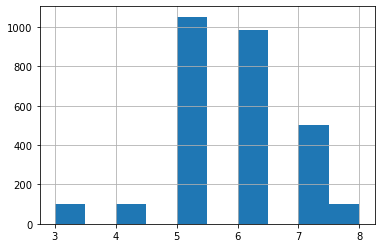

In [30]:
y_resampled.hist()

In [31]:
rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_resampled, y_resampled-3)
y_pred = rfc.predict(X_valid)

print(f"Accuracy Score for {accuracy_score(y_valid -3 , y_pred)}", )
print(f"F1 Score for {f1_score(y_valid-3 ,y_pred, average='weighted')}")
quadratic_weighted_kappa(y_valid - 3, y_pred)


Accuracy Score for 0.6203125
F1 Score for 0.6060370409905149


0.5403340615367513

<AxesSubplot:>

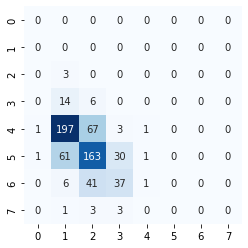

In [32]:
conf_mat = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [33]:
#bbc = BalancedBaggingClassifier(random_state=SEED)
#bbc.fit(X_resampled, y_resampled-3)
#y_pred = bbc.predict(X_valid)

#
#print(f"Accuracy Score for {accuracy_score(y_valid -3 , y_pred)}", )
#print(f"F1 Score for {f1_score(y_valid-3 ,y_pred, average='weighted')}")
#uadratic_weighted_kappa(y_valid - 3, y_pred)

In [34]:
sample = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")

In [35]:
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


In [36]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acid,acid/density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorides,sulphates*alcohol
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,8.89,8.928213,12.048212,0.773310,1.540000,10.547945,0.063636
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,10.33,10.345104,12.781312,0.670980,2.233333,7.282609,0.052344
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,7.64,7.666065,11.261580,0.732490,1.431373,12.372881,0.064602
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,9.19,9.214880,9.773540,0.531435,0.609195,6.309524,0.054082
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,9.16,9.211214,9.447180,1.367604,3.777778,17.215190,0.143158


In [37]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(sampling_strategy={3: 100, 4: 100, 7:500, 8:100},
                                random_state=SEED,
                                k_neighbors = 3,
                                 
                                ).fit_resample(features_df, targets_df)

In [38]:
rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_resampled, y_resampled-3)



RandomForestClassifier(random_state=88888)

In [39]:
test_df = create_new_features(test) 


test_df = test_df.drop(["Id"], axis=1)
scaler = QuantileTransformer(output_distribution="normal")
train_scl = scaler.fit_transform(test_df)
print(type(train_scl ))
test_df = pd.DataFrame(train_scl, columns = features_df.columns)




y_pred = rfc.predict(test_df )


<class 'numpy.ndarray'>


In [40]:
y_pred

array([2, 2, 3, ..., 2, 2, 2])

In [41]:
sample["quality"] = y_pred  +3

In [42]:
sample

,Id,quality
0,2056,5
1,2057,5
2,2058,6
3,2059,6
4,2060,6
...,...,...
1367,3423,5
1368,3424,7
1369,3425,5
1370,3426,5


In [43]:
sample.to_csv('submission.csv', index=False)